# _Trial 29_

__July 11, 2019__

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

# _Load in Data_

In [5]:
from capstone import sample

In [6]:
train_df, valid_df = sample.prep_data(path);

Read in training and validation data sets
------------------------------
Added column to both data sets that indicates if observation is part of validation set or not.
------------------------------
Extracted patient ID and study number for each observation and assigned into new columns.
------------------------------
Filled in NaNs within pathology columns with 0 (see Stanford ML Github for further information on dealing with NaNs).
------------------------------
Converted pathology columns to integer type.
------------------------------
Pre-replacement Label Distribution: Label 0 = 188327, Label 1 = 27000, Label -1 = 8087
------------------------------
Replaced uncertain labels in Cardiomegaly column with 0 (i.e. negative)
Post-replacement Label Distribution: Label 0 = 196414, Label 1 = 27000
Does number of post-replacement 0 labels equal the sum of pre-replacement -1s and 0s? True
Returned training and validation data sets as pandas dataframes.


In [7]:
# set seed to help with reproducibility
sample.set_seed(1)

In [8]:
full_df = sample.oversample_and_prep(train_df, valid_df, 0.4);

Created two new data sets, one with positive observations and the other with the negatives.
The shape of dataframe containing 0 (negative) labels: (196414, 22)
The shape of dataframe containing 1 (positive) labels: (27000, 22)
------------------------------
Random over-sampling: 
1    196414
0    196414
Name: Cardiomegaly, dtype: int64
------------------------------
Sampled from over-sampled dataframe.
Value Counts for Cardiomegaly column in new dataframe: 
1    78700
0    78431
Name: Cardiomegaly, dtype: int64
------------------------------
Concatenated oversampled training data set with validation data.
Returning full data set.


In [9]:
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient29646/study2/...,Male,37,Frontal,AP,0,0,0,-1,0,1,1,0,-1,0,1,0,0,0,False,patient29646,study2
1,CheXpert-v1.0-small/train/patient07979/study17...,Female,51,Frontal,AP,0,0,0,1,0,1,0,0,0,0,1,0,0,1,False,patient07979,study17
2,CheXpert-v1.0-small/train/patient37584/study2/...,Male,55,Frontal,AP,0,1,1,1,0,1,-1,0,-1,0,1,0,0,-1,False,patient37584,study2
3,CheXpert-v1.0-small/train/patient04193/study4/...,Male,83,Frontal,AP,0,0,1,1,0,1,0,0,0,0,0,0,0,0,False,patient04193,study4
4,CheXpert-v1.0-small/train/patient26475/study1/...,Male,78,Frontal,AP,0,0,1,-1,0,0,1,0,0,0,0,0,0,1,False,patient26475,study1


# _Deep Learning Fast.ai Set Up_

In [10]:
from capstone import replicate

src = replicate.get_src(full_df, path, feature_col='Cardiomegaly')

In [11]:
# use an initial image size of 64
data = replicate.get_data(64, src, default_trans = False)

using bs=16, have 7601MB of GPU RAM free.
------------------------------
Data ready.


In [49]:
data

ImageDataBunch;

Train: LabelList (157131 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

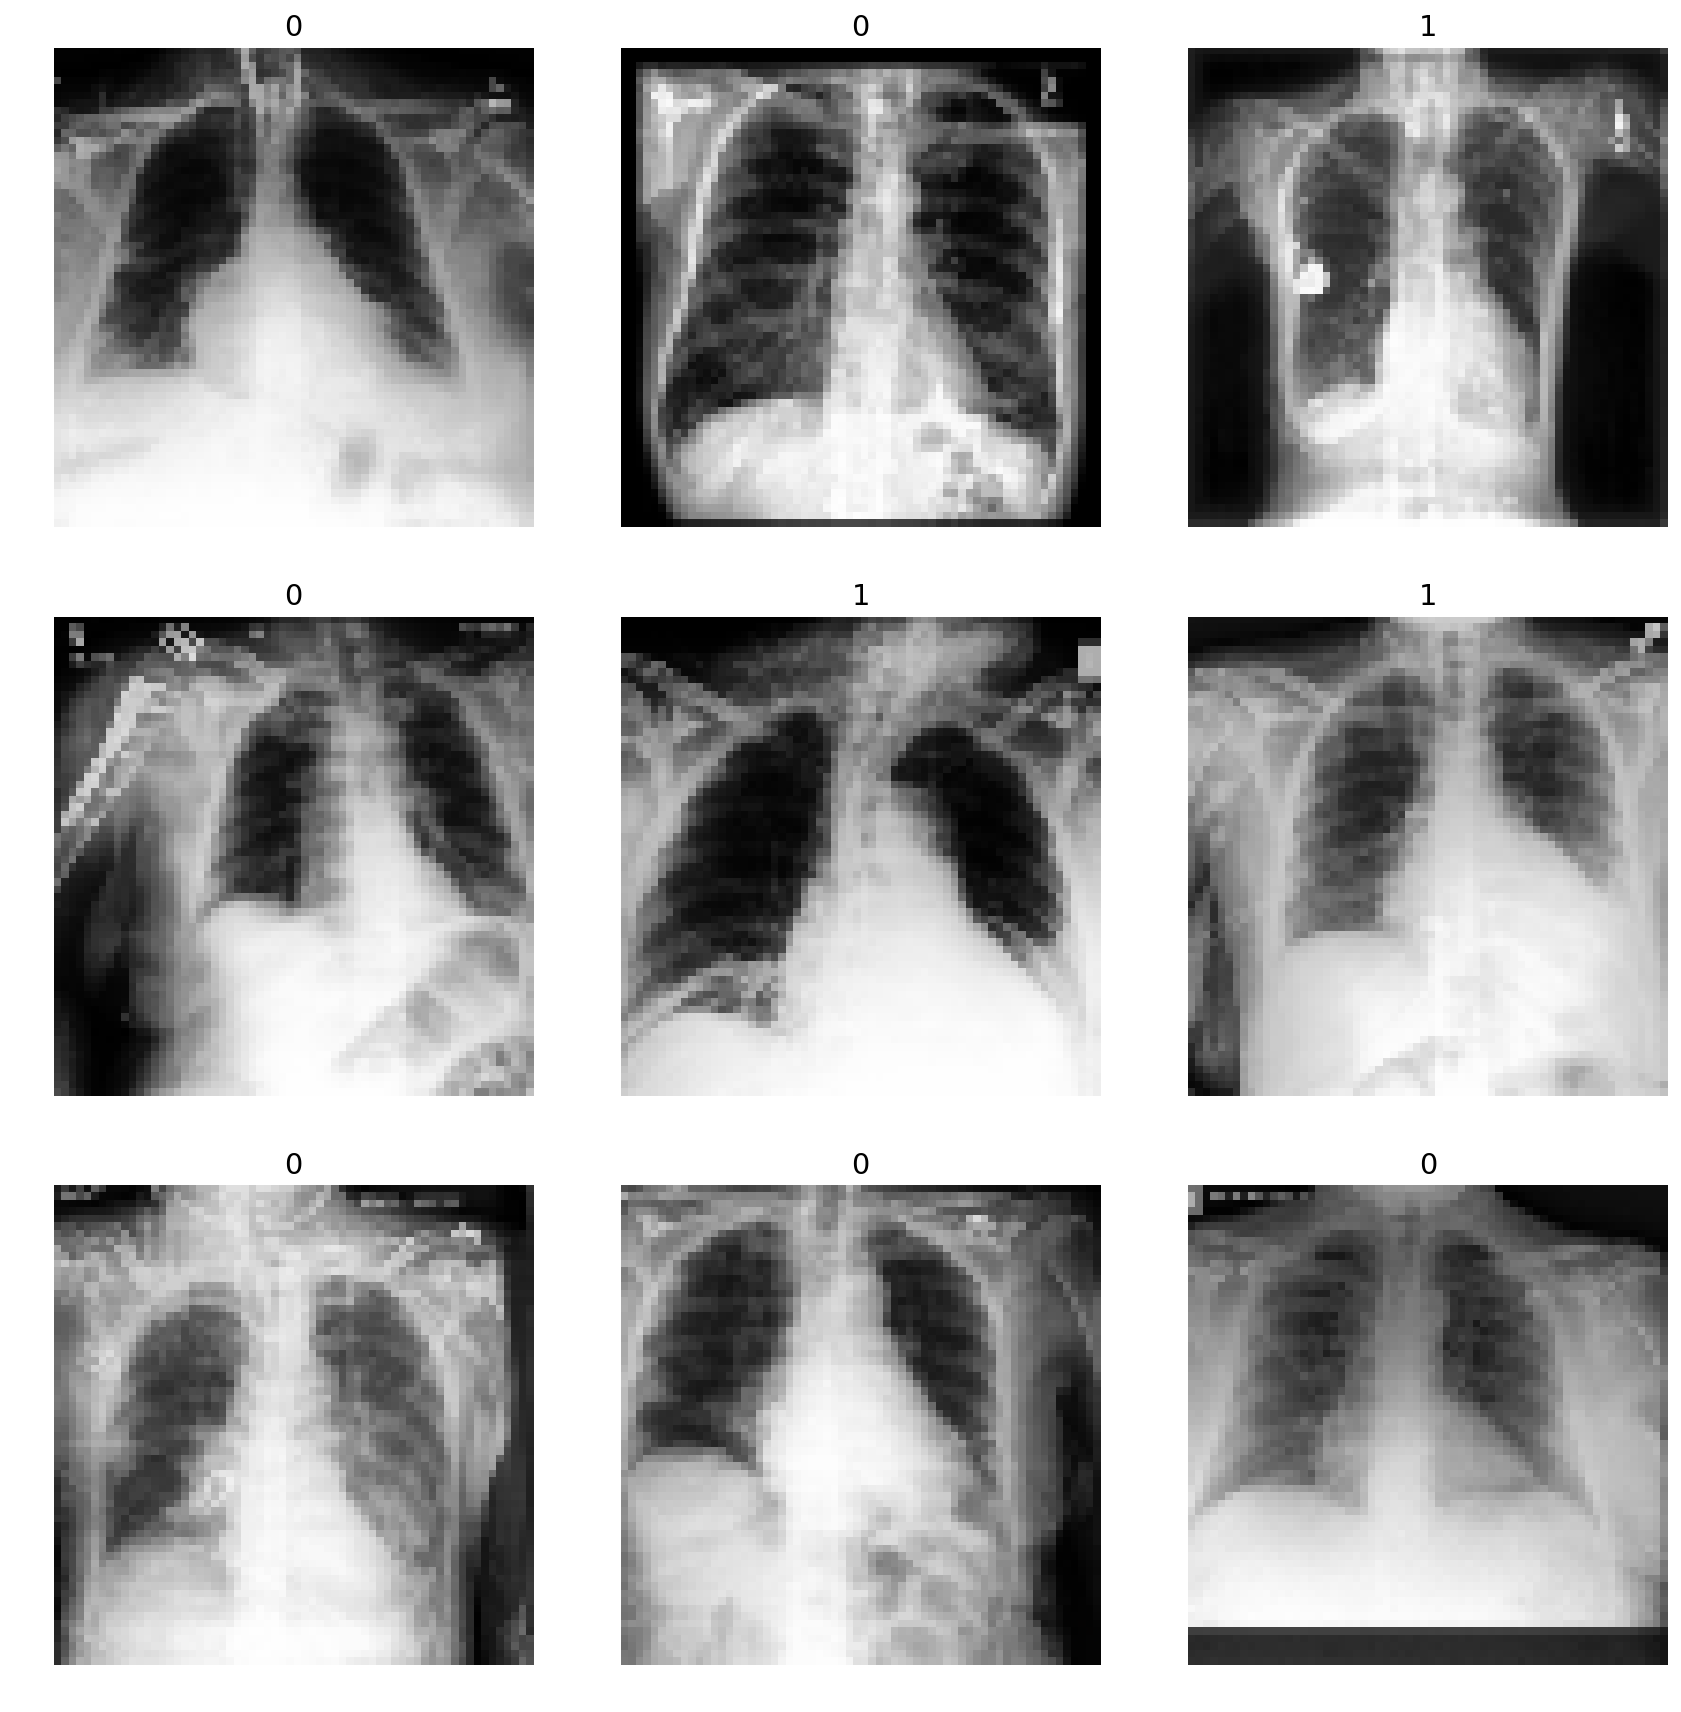

In [50]:
data.show_batch(rows=3)

# _Create DenseNet Model_

__First Round of Training__

In [12]:
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[AUROC(), Precision(), Recall()],
                    pretrained=True, ps=0.5, bn_final=True)

In [52]:
# load best performing weights from trial 28
#learn.load('best_densenet121_trial28-rd2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.70E-03
Min loss divided by 10: 3.63E-01


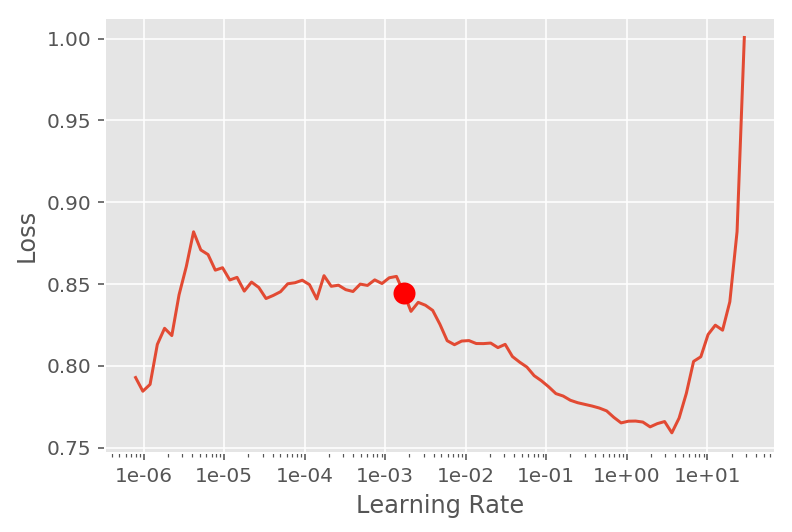

In [53]:
from capstone import deeplearning

deeplearning.lr_finder_plot(learn);

In [54]:
learn.fit_one_cycle(3, 9e-2, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial29-rd1')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.596054,0.463575,0.831680,0.727273,0.470588,22:03
1,0.596986,0.516468,0.763643,0.764706,0.191176,22:24
2,0.571011,0.502146,0.786410,0.653846,0.500000,22:46


Better model found at epoch 0 with auroc value: 0.83167964220047.


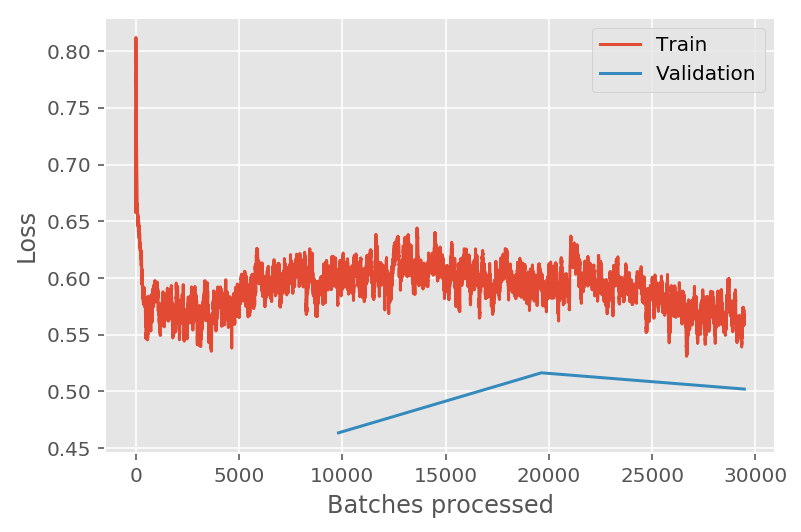

In [55]:
learn.recorder.plot_losses()

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

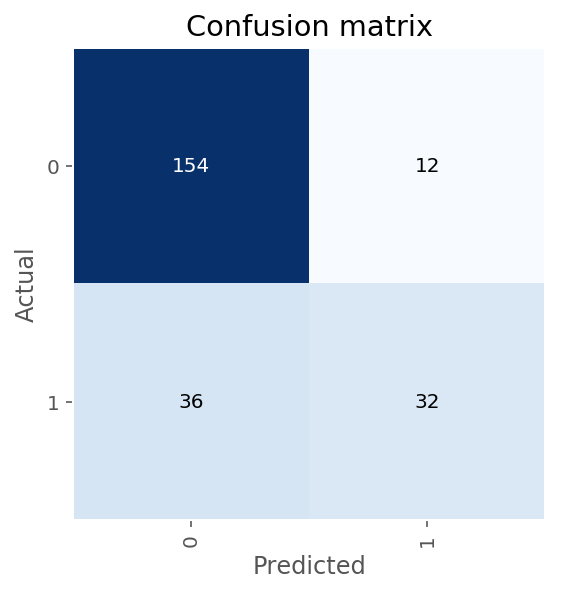

In [57]:
interp.plot_confusion_matrix()

# _Train on Under-sampled Data_

In [13]:
full_df_under = sample.undersample_and_prep(train_df, valid_df);

Created two new data sets, one with positive observations and the other with the negatives.
The shape of dataframe containing 0 (negative) labels: (196414, 22)
The shape of dataframe containing 1 (positive) labels: (27000, 22)
------------------------------
Random under-sampling: 
1    27000
0    27000
Name: Cardiomegaly, dtype: int64
------------------------------
Reshuffled rows in new undersampled dataframe.
------------------------------
Concatenated undersampled training data set with validation data.
Returning full data set.


In [14]:
src_under = replicate.get_src(full_df_under, path, feature_col='Cardiomegaly')

In [15]:
# use image size of 64 on undersampled data
data_under = replicate.get_data(64, src_under)

using bs=16, have 7110MB of GPU RAM free.
------------------------------
Data ready.


In [16]:
learn.data = data_under

In [17]:
learn.data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Second Round of Training w/ Undersampled Data Set_

In [64]:
learn.load('best_densenet121_trial29-rd1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-07
Min loss divided by 10: 9.77E-08


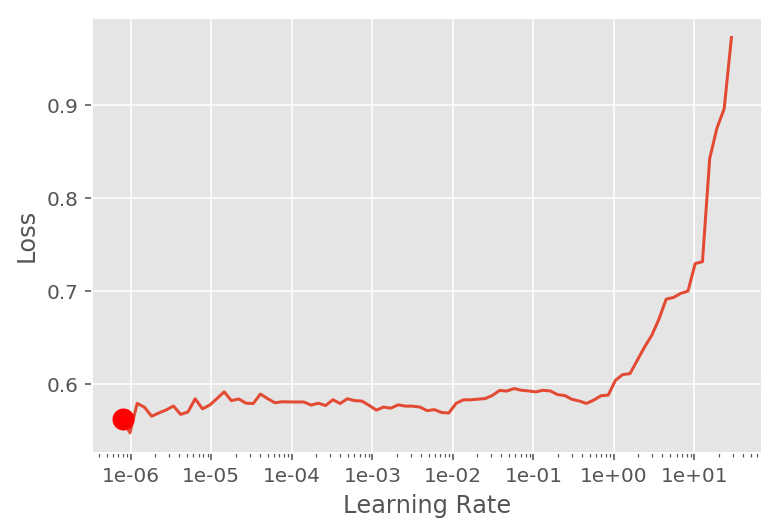

In [65]:
deeplearning.lr_finder_plot(learn);

In [66]:
learn.fit_one_cycle(3, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial29-rd2')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.576730,0.485350,0.831857,0.645161,0.588235,07:37
1,0.575601,0.478528,0.823795,0.666667,0.470588,07:47
2,0.576834,0.476618,0.819986,0.642857,0.529412,07:39


Better model found at epoch 0 with auroc value: 0.831856906414032.


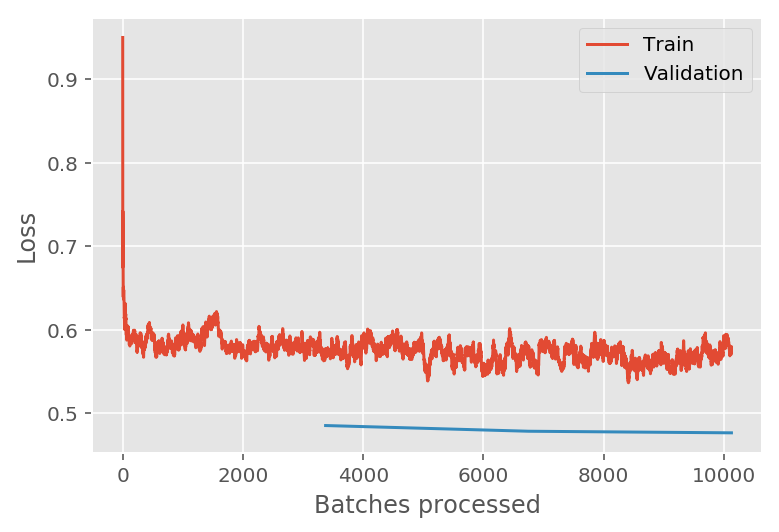

In [71]:
learn.recorder.plot_losses()

# _Resize Images to 128_

In [75]:
# use image size of 128 on undersampled data
data_under = replicate.get_data(128, src_under)

using bs=16, have 7002MB of GPU RAM free.
------------------------------
Data ready.


In [76]:
learn.data = data_under

In [77]:
learn.data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,1,0,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Third Round of Training with Image Size = 128_

In [78]:
learn.load('best_densenet121_trial29-rd2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.77E-07
Min loss divided by 10: 1.95E-01


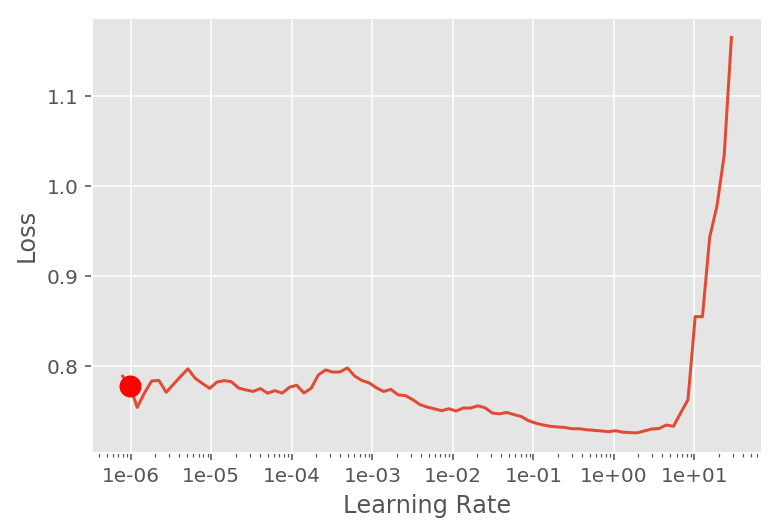

In [79]:
deeplearning.lr_finder_plot(learn);

In [80]:
learn.fit_one_cycle(3, 5e-3, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial29-rd3')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.565161,0.511056,0.770819,0.583333,0.411765,08:11
1,0.566324,0.469709,0.823972,0.649123,0.544118,08:11
2,0.565632,0.478393,0.812190,0.627119,0.544118,08:10


Better model found at epoch 0 with auroc value: 0.7708185911178589.
Better model found at epoch 1 with auroc value: 0.8239723443984985.


# _Resize Images to 256_

In [18]:
# use image size of 256 on undersampled data
data_under_256 = replicate.get_data(256, src_under)

using bs=16, have 7110MB of GPU RAM free.
------------------------------
Data ready.


In [19]:
learn.data = data_under_256

In [20]:
learn.data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Fourth Round of Training with Image Size = 256_

In [21]:
learn.load('best_densenet121_trial29-rd3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.24E-06
Min loss divided by 10: 1.29E-01


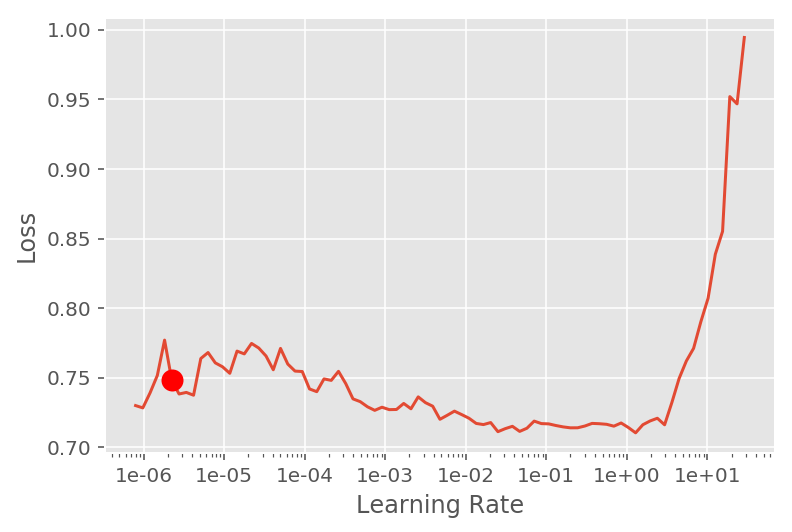

In [23]:
from capstone import deeplearning

deeplearning.lr_finder_plot(learn);

In [86]:
lr = learn.recorder.min_grad_lr
lr

1.2022644346174128e-06

In [24]:
learn.fit_one_cycle(3, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial29-rd4')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.619002,0.547616,0.761428,0.514286,0.529412,13:19
1,0.588739,0.495811,0.816265,0.625000,0.588235,13:12
2,0.572799,0.491243,0.814582,0.616667,0.544118,13:15


Better model found at epoch 0 with auroc value: 0.7614280581474304.
Better model found at epoch 1 with auroc value: 0.8162650465965271.


# _Resize Images to 320_ CONTINUE HERE JULY 12

In [25]:
# use image size of 320 on undersampled data
data_under_320 = replicate.get_data(320, src_under)

using bs=16, have 7030MB of GPU RAM free.
------------------------------
Data ready.


In [26]:
learn.data = data_under_320

In [27]:
learn.data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Fifth Round of Training with Image Size = 320_

In [38]:
learn.load('best_densenet121_trial29-rd4');

In [39]:
deeplearning.lr_finder_plot(learn);

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.43 GiB total capacity; 6.80 GiB already allocated; 16.94 MiB free; 138.84 MiB cached)

In [35]:
lr = learn.recorder.min_grad_lr
lr

3.388441561392026e-06

In [37]:
learn.fit_one_cycle(3, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial29-rd5')])

epoch,train_loss,valid_loss,auroc,precision,recall,time


RuntimeError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 7.43 GiB total capacity; 6.79 GiB already allocated; 18.94 MiB free; 149.98 MiB cached)